In [1]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,  Activation, Conv2D, MaxPool2D,ConvLSTM2D, MaxPooling2D,LSTM,Conv1D,MaxPool1D,GlobalAveragePooling1D,TimeDistributed,MaxPooling1D
from keras.layers import Flatten, Dropout, BatchNormalization, Reshape
from keras.utils.vis_utils import plot_model

import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
signals = pd.read_csv("signals.csv")
metadata = pd.read_csv("metadata.csv")
signals_test = pd.read_csv("signals_test.csv")
metadata_test = pd.read_csv("metadata_test.csv")
signals.shape

(811637, 5)

In [3]:
m = metadata[metadata['x-axis__length']!=100]
m_test = metadata_test[metadata_test['x-axis__length']!=100].copy()
m_test
signals = signals[~signals.user_snippet.isin(m['user_snippet'].values)]
signals.shape

(810100, 5)

In [4]:
merged = pd.merge(signals, metadata[['user_snippet', 'activity']], on='user_snippet')
merged.head(10)


,user_snippet,x-axis,y-axis,z-axis,timestamp,activity
0,1008_0,-5.01,10.99,4.75,0.0,Upstairs
1,1008_0,-2.72,13.25,4.44,50.0,Upstairs
2,1008_0,5.41,13.18,1.27,100.0,Upstairs
3,1008_0,-1.80,0.15,-2.72,150.0,Upstairs
4,1008_0,-2.91,-3.87,-2.49,200.0,Upstairs
5,1008_0,-3.87,-0.91,1.80,250.0,Upstairs
6,1008_0,-3.64,-2.22,2.83,300.0,Upstairs
7,1008_0,-9.11,-0.84,10.95,350.0,Upstairs
8,1008_0,-14.06,3.60,13.44,400.0,Upstairs
9,1008_0,-10.46,3.64,5.79,450.0,Upstairs


In [5]:
merged.shape

(810100, 6)

In [6]:
def clean_data(dataframe):
    """ Removes the columns "SubjectID" and "Timestamp" from the dataframe """

    cleaned_df = dataframe.drop(["timestamp"], axis = 1).copy()

    return cleaned_df

In [7]:
def scale_data(data):
    """ Normalizes the data using StandardScaler() function """
    
    le = LabelEncoder()
    data['ActivityCode'] = le.fit_transform(data['activity'])
    
    X = data[['x-axis', 'y-axis', 'z-axis']]
    y = data['ActivityCode']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    scaled_df = pd.DataFrame(data = X, columns = ['x-axis', 'y-axiz', 'z-axis'])
    scaled_df['user_snippet'] = data['user_snippet']
    scaled_df['ActivityCode'] = y.values
    
    return scaled_df, le, scaler

In [8]:
def preprocess_data(dataframe):    
    """ Preprocesses the data using clean() and scale() functions """

    cleaned_df = clean_data(dataframe)
    
    return scale_data(cleaned_df)

In [9]:
def plot_learningCurve(history, epochs):
    """ Plots training & validation accuracy values """

    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history["val_accuracy"])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    
    """ Plots training & validation loss values """
    
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [10]:
import scipy.stats as stats
def get_frames(df):
    n_features = 3
    frames = []
    labels = []
    #users = df['user_snippet'].unique()
    for i in range(0, len(df) - 100, 100):
        
       
        
        z = df['z-axis'].values[i: i + 100]
        x = df['x-axis'].values[i: i + 100]
        y = df['y-axiz'].values[i: i + 100]
        
        
        label = stats.mode(df['ActivityCode'][i: i + 100])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, 100, n_features)
    labels = np.asarray(labels)

    return frames, labels

In [11]:
def get_model(inputs):
    """ Builds the model (the Convolutional Neural Network) """
    
    # Defines model
    model = Sequential()
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = inputs[0].shape))
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = inputs[0].shape))
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = inputs[0].shape))
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = inputs[0].shape))



#     model.add(Dropout(0.1))
#     model.add(Conv2D(64, (2, 2), activation='relu'))
#     model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    # Compiles model
    model.compile(optimizer=Adam(learning_rate = 0.0001), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    return model
def get_model2(input):
    input_shape = input_shape.shape
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
    model.add(LSTM(32,return_sequences=True, activation='relu'))
    model.add(Reshape((1, 240, 32)))
    model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
    model.add(Reshape((120, 64)))
    model.add(MaxPool1D(pool_size=4, padding='same'))
    model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
    model.add(Reshape((29, 192)))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization(epsilon=1e-06))
    model.add(Dense(6))
    model.add(Activation('softmax'))
    print(model.summary())
    return model

In [12]:
process_data,le,scaler = preprocess_data(merged)
process_data.shape

(810100, 5)

In [13]:
X, y = get_frames(process_data)

In [14]:
X.shape

(8100, 100, 3)

In [15]:
time_period, sensors = X.shape[1], X.shape[2]

In [16]:
input_shape = time_period * sensors
x_train = X.reshape(X.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", X.shape)

Input Shape:  300
Input Data Shape:  (8100, 100, 3)


In [17]:
x_train = X.astype('float32')
y_train = y.astype('float32')

In [18]:
from tensorflow.keras.utils import to_categorical
y_train_hot = to_categorical(y_train, 6)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (8100, 6)


In [19]:
# reset tensorflow session
from tensorflow.keras import backend as K
K.clear_session()

In [38]:
from keras.regularizers import L1L2

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=7, activation='relu'), input_shape=(1,100,3)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=7, activation='relu')))
model.add(TimeDistributed(Dropout(0.8)))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Conv1D(filters=512, kernel_size=5, activation='relu')))
model.add(TimeDistributed(Dropout(0.8)))
model.add(TimeDistributed(MaxPooling1D(pool_size=3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256))
model.add(Dropout(0.8))
model.add(Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 1, 94, 128)       2816      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 1, 88, 256)       229632    
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 1, 88, 256)       0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 1, 29, 256)       0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 1, 25, 512)      

In [39]:
x_train = x_train.reshape((x_train.shape[0], 1,100,3))
x_train.shape

(8100, 1, 100, 3)

In [40]:
#x_train = x_train.reshape(-1,100,3)

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train_hot,
                    batch_size= 128, 
                    validation_split=0.2,
                    epochs=50
                   )

Epoch 1/50
51/51 [==============================] - 117s 2s/step - loss: 2.9637 - accuracy: 0.5932 - val_loss: 2.3385 - val_accuracy: 0.7772
Epoch 2/50
51/51 [==============================] - 117s 2s/step - loss: 1.8696 - accuracy: 0.7725 - val_loss: 1.5120 - val_accuracy: 0.8481
Epoch 3/50
51/51 [==============================] - 109s 2s/step - loss: 1.3345 - accuracy: 0.8068 - val_loss: 1.1667 - val_accuracy: 0.8500
Epoch 4/50
51/51 [==============================] - 93s 2s/step - loss: 1.0297 - accuracy: 0.8304 - val_loss: 0.9904 - val_accuracy: 0.8432
Epoch 5/50
51/51 [==============================] - 101s 2s/step - loss: 0.8238 - accuracy: 0.8466 - val_loss: 0.9443 - val_accuracy: 0.7901
Epoch 6/50
51/51 [==============================] - 97s 2s/step - loss: 0.6763 - accuracy: 0.8662 - val_loss: 0.8206 - val_accuracy: 0.7981
Epoch 7/50
51/51 [==============================] - 115s 2s/step - loss: 0.5721 - accuracy: 0.8847 - val_loss: 0.6327 - val_accuracy: 0.8938
Epoch 8/50
51/5

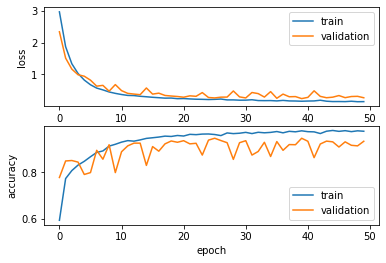

In [41]:
def plot_history(history):
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'])
    
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    return;

plot_history(history)

In [42]:
m_test = metadata_test[metadata_test['x-axis__length']!=100].copy()
signals_new = signals_test[~signals_test.user_snippet.isin(m_test['user_snippet'].values)]
signals_new.shape

(261300, 5)

In [43]:
X = signals_new[['x-axis', 'y-axis', 'z-axis']]

X = scaler.transform(X)

scaled_df = pd.DataFrame(data = X, columns = ['x-axis', 'y-axiz', 'z-axis'])
scaled_df['user_snippet'] = signals_new['user_snippet']

In [44]:
n_features = 3
frames = []

#users = df['user_snippet'].unique()
for i in range(0, len(scaled_df), 100):
    
    
    
    z = scaled_df['z-axis'].values[i: i + 100]
    x = scaled_df['x-axis'].values[i: i + 100]
    y = scaled_df['y-axiz'].values[i: i + 100]
    
    
    
    frames.append([x, y, z])

frames = np.asarray(frames).reshape(-1, 100, n_features)


In [45]:
frames = frames.reshape(-1,1, 100,3)
y_pred = model.predict(frames, verbose=0)
classes_x=np.argmax(y_pred,axis=1)
len(classes_x)

2613

In [46]:
predictions = le.inverse_transform(classes_x)


In [47]:
final = metadata_test[metadata_test['x-axis__length']==100.0].copy()
final['prediction'] = predictions

In [48]:
pred = pd.DataFrame(data = final, columns = ['user_snippet', 'prediction'])

In [49]:
ensemble = pd.read_csv('ensemble7.csv')

In [50]:
others = ensemble[~ensemble.user_snippet.isin(pred['user_snippet'].values)]
others

,user_snippet,prediction
320,2066_320,Downstairs
563,2069_202,Standing
820,2178_137,Downstairs
954,2203_50,Upstairs
1415,2235_129,Sitting
1868,2346_139,Standing
2105,2383_152,Standing
2554,2480_267,Downstairs


In [51]:
c = pd.concat([pred,others])
c.shape

(2621, 2)

In [52]:
check = pd.merge(ensemble, c, on='user_snippet')
check

,user_snippet,prediction_x,prediction_y
0,2066_0,Upstairs,Upstairs
1,2066_1,Walking,Walking
2,2066_2,Jogging,Jogging
3,2066_3,Walking,Walking
4,2066_4,Walking,Walking
...,...,...,...
2616,2480_329,Walking,Walking
2617,2480_330,Walking,Walking
2618,2480_331,Downstairs,Walking
2619,2480_332,Sitting,Sitting


In [53]:
confusion_matrix(check['prediction_x'],check['prediction_y'])

array([[202,   1,   1,   0,  19,   9],
       [ 18, 789,   0,   0,   2,   1],
       [  0,   0,  98,   0,   3,   0],
       [  0,   0,   2, 106,   0,   1],
       [ 79,   1,   0,   0, 359,  27],
       [  7,   0,   0,   0,   3, 893]], dtype=int64)

In [57]:
check['prediction'] = check['prediction_y']
check= check.drop(columns=['prediction_x','prediction_y'])

KeyError: 'prediction_y'

In [ ]:
check.to_csv("submitRawCNN29.csv",index=False)

In [59]:


pred1 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble9.csv")
pred12 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble8.csv")
pred2 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN23.csv")
pred6 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble7.csv")
pred7 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble6.csv")
pred15 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitSVMLP.csv")
pred16 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN24.csv")
pred18 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN26.csv")
pred19 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble14.csv")
pred20 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble12.csv")
pred21= pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble11.csv")
pred23 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN22.csv")
pred24 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN27.csv")
pred25 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble17.csv")
pred27 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble21.csv")
pred28 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble20.csv")
pred29 = pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/ensemble19.csv")
pred26= pd.read_csv("c:/Users/sarah/OneDrive - Liverpool John Moores University/LJMU/ML/Project/SVM/submitRawCNN29.csv")





In [60]:
df = pd.DataFrame()
predictions = [pred1,pred12,pred2,pred6,pred7, pred12,pred15,pred16,pred18, pred19, pred20,pred21,pred23, pred24, pred25, pred27,pred28,pred29,pred26]
for i in range (0, len(predictions)):
    df[i] = predictions[i]['prediction']

In [61]:
final = df.mode(axis=1)
pred2['prediction'] = final[0]
pred2.to_csv("ensemble22.csv",index=False)
